In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn import svm
from Utils import GeoUtils

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

%matplotlib inline

# Data Handling

In [21]:
data = pd.read_csv("Dados/LocTreino_Equipe_4.csv")

bts_data = pd.read_csv("Dados/dados_BTSs.csv")

In [22]:
bts_data.describe()

,lat,lon,bcch,eirp
count,6.000000,6.000000,6.000000,6.000000e+00
mean,-8.071190,-34.895662,696.500000,5.559000e+01
std,0.005477,0.006370,54.617763,7.783606e-15
min,-8.076361,-34.908000,662.000000,5.559000e+01
25%,-8.075917,-34.894611,667.750000,5.559000e+01
50%,-8.072139,-34.894597,677.500000,5.559000e+01
75%,-8.066590,-34.893187,688.000000,5.559000e+01
max,-8.064583,-34.889444,806.000000,5.559000e+01


In [23]:
data.drop_duplicates(inplace=True)
data.shape
data = data.drop(['pontoId'], axis=1)
data['taBTS2'] = data['taBTS2'].fillna(data['taBTS2'].mean())
data['taBTS4'] = data['taBTS4'].fillna(data['taBTS4'].mean())

# bts1_coord = np.tile(bts_data[['lat', 'lon']].iloc[0].values, (1500,1))
# data['distBTS1'] = getDistance(data[['lat', 'lon']].values, bts1_coord) 

# bts2_coord = np.tile(bts_data[['lat', 'lon']].iloc[1].values, (1500,1))
# data['distBTS2'] = getDistance(data[['lat', 'lon']].values, bts2_coord) 

# bts3_coord = np.tile(bts_data[['lat', 'lon']].iloc[2].values, (1500,1))
# data['distBTS3'] = getDistance(data[['lat', 'lon']].values, bts2_coord) 

# bts4_coord = np.tile(bts_data[['lat', 'lon']].iloc[3].values, (1500,1))
# data['distBTS4'] = getDistance(data[['lat', 'lon']].values, bts2_coord) 

# bts5_coord = np.tile(bts_data[['lat', 'lon']].iloc[4].values, (1500,1))
# data['distBTS5'] = getDistance(data[['lat', 'lon']].values, bts2_coord) 

# bts6_coord = np.tile(bts_data[['lat', 'lon']].iloc[5].values, (1500,1))
# data['distBTS6'] = getDistance(data[['lat', 'lon']].values, bts2_coord) 

data.describe()

,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6,taBTS1,taBTS2,taBTS3,taBTS4,taBTS5,taBTS6
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.0000
mean,-8.070097,-34.894814,116.654370,119.101165,123.863545,115.814052,121.320526,125.656192,0.663333,1.008733,2.525333,1.099388,1.093333,1.0560
std,0.004232,0.004354,15.229664,12.666188,9.031316,12.414620,12.552702,13.134365,0.698317,0.863886,0.967117,1.954747,0.856998,0.6692
min,-8.077570,-34.906830,86.256667,77.256667,88.340000,84.056667,79.523333,89.856667,0.000000,0.000000,1.000000,0.000000,0.000000,0.0000
25%,-8.073197,-34.897387,106.827500,111.673333,119.190000,106.583750,112.823333,116.077500,0.000000,0.000000,2.000000,0.000000,0.000000,1.0000
50%,-8.069940,-34.895346,117.156667,120.690000,124.273333,116.273333,122.840000,128.756667,1.000000,1.000000,3.000000,1.000000,1.000000,1.0000
75%,-8.067113,-34.891169,124.790000,128.808750,130.117083,125.590000,130.423333,135.996250,1.000000,1.000000,3.000000,1.000000,2.000000,2.0000
max,-8.059339,-34.885067,476.882449,144.890000,145.890000,145.423333,146.890000,150.123333,3.000000,11.090452,5.000000,38.747484,3.000000,2.0000


In [24]:
x = data.drop(['lat', 'lon'], axis=1)

transformerX = StandardScaler().fit(x)
x_scaled = transformerX.transform(x)

In [25]:
y = data[['lat', 'lon']]
y.describe()

,lat,lon
count,1500.000000,1500.000000
mean,-8.070097,-34.894814
std,0.004232,0.004354
min,-8.077570,-34.906830
25%,-8.073197,-34.897387
50%,-8.069940,-34.895346
75%,-8.067113,-34.891169
max,-8.059339,-34.885067


# Testing Regressors

In [26]:
transformerY = StandardScaler().fit(y)
y_scaled = transformerY.transform(y)


X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size = 0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

invX = transformerX.inverse_transform
invY = transformerY.inverse_transform

(1050, 12) (450, 12) (1050, 2) (450, 2)


## XGBoost

In [31]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
multioutputregressor = MultiOutputRegressor(model_xgb).fit(X_train, y_train)

In [32]:
realoutp = invY(multioutputregressor.predict(X_test))
realoutr = invY(y_test)                                         
print (realoutp)

[[ -8.077877  -34.89835  ]
 [ -8.065796  -34.88787  ]
 [ -8.068931  -34.90016  ]
 [ -8.065353  -34.8977   ]
 [ -8.0685425 -34.890053 ]
 [ -8.072039  -34.89608  ]
 [ -8.073559  -34.900406 ]
 [ -8.062928  -34.886482 ]
 [ -8.072511  -34.893204 ]
 [ -8.066331  -34.89597  ]
 [ -8.063766  -34.895313 ]
 [ -8.069811  -34.89041  ]
 [ -8.072475  -34.892124 ]
 [ -8.075935  -34.89982  ]
 [ -8.064929  -34.901928 ]
 [ -8.06417   -34.888332 ]
 [ -8.069466  -34.899487 ]
 [ -8.072455  -34.891785 ]
 [ -8.068909  -34.890266 ]
 [ -8.066588  -34.888607 ]
 [ -8.069482  -34.890045 ]
 [ -8.064199  -34.885437 ]
 [ -8.069135  -34.897984 ]
 [ -8.069019  -34.89635  ]
 [ -8.074869  -34.89761  ]
 [ -8.075146  -34.893154 ]
 [ -8.073844  -34.90016  ]
 [ -8.071007  -34.892044 ]
 [ -8.072544  -34.895985 ]
 [ -8.075679  -34.90017  ]
 [ -8.070823  -34.896362 ]
 [ -8.071649  -34.891796 ]
 [ -8.074445  -34.900154 ]
 [ -8.076705  -34.899544 ]
 [ -8.072551  -34.895653 ]
 [ -8.070612  -34.89573  ]
 [ -8.06955   -34.900036 ]
 

In [33]:
print (np.mean((realoutp - realoutr)**2, axis=0))

[2.84865634e-07 3.42475030e-07]


In [34]:
def getDistance(real, predict):
    lat1 = real[:,0]
    lon1 = real[:,1]
    lat2 = predict[:,0]
    lon2 = predict[:,1]

    return np.array(GeoUtils.GeoUtils.distanceInKm(lat1, lon1,lat2, lon2))

print(getDistance(realoutr, realoutp).mean())

0.07204969924368021


## Support Vector Regression

In [35]:
svr = svm.SVR()
regr = MultiOutputRegressor(svr)
regr.fit(X_train,y_train)

svmreal = invY(y_test)
svmpredict = invY(regr.predict(X_test))

print(getDistance(svmreal, svmpredict).mean())

0.06247777738912915


In [13]:
print (np.mean((svmpredict - svmreal)**2, axis=0))

[2.36077252e-07 2.49451427e-07]


## Lasso

In [14]:
lasso = MultiOutputRegressor(Lasso(alpha =0.0005, random_state=1))
lasso.fit(X_train, y_train)

lassoreal = invY(y_test)
lassopredict = invY(lasso.predict(X_test))

print(getDistance(lassoreal, lassopredict).mean())

0.1675220001517267


## Elastic Net 

In [15]:
elastic = MultiOutputRegressor(ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
elastic.fit(X_train, y_train)

elasticreal = invY(y_test)
elasticpredict = invY(elastic.predict(X_test))

print(getDistance(elasticreal, elasticpredict).mean())

0.16755728081347407


## Kernel Ridge

In [16]:
kridge = MultiOutputRegressor(KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5))
kridge.fit(X_train, y_train)

kridgereal = invY(y_test)
kridgepredict = invY(kridge.predict(X_test))

print(getDistance(kridgereal, kridgepredict).mean())

0.09002820296607118


## Gradient Boosting

In [17]:
gboost = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=50, max_features='sqrt',
                                   min_samples_leaf=5, min_samples_split=10, 
                                   loss='huber', random_state =5))
gboost.fit(X_train, y_train)

gboostreal = invY(y_test)
gboostpredict = invY(gboost.predict(X_test))

print(getDistance(gboostreal, gboostpredict).mean())

0.07153124073206005


In [18]:
# NAO PEGA NO MAC
# lgbm = MultiOutputRegressor(lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11))

# lgbm.fit(X_train, y_train)

# lgbmreal = invY(y_test)
# lgbmpredict = invY(lgbm.predict(X_test))

# print(getDistance(lgbmreal, lgbmpredict).mean())

## KNN

In [41]:
knn = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=3))
knn.fit(X_train, y_train)

knnreal = invY(y_test)
knnpredict = invY(knn.predict(X_test))

print(getDistance(knnreal, knnpredict).mean())

0.04535385442015248


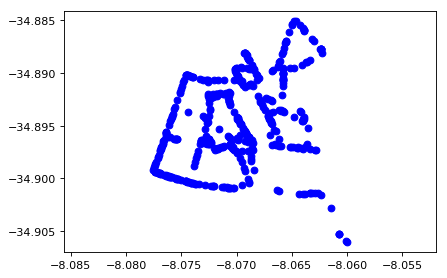

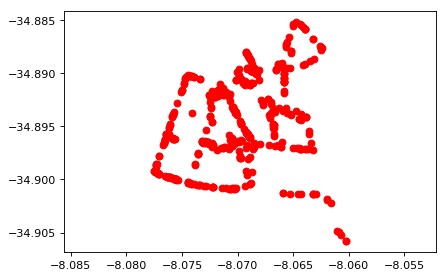

In [20]:
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(knnreal[:,0], knnreal[:,1], c='blue')
plt.margins(x=0.0, y=-0.25)
plt.show()

figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(knnpredict[:,0], knnpredict[:,1], c='red')
plt.margins(x=0.0, y=-0.25)
plt.show()

In [21]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [22]:
knn = KNeighborsRegressor(n_neighbors=5)
gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=50, max_features='sqrt',
                                   min_samples_leaf=5, min_samples_split=10, 
                                   loss='huber', random_state =5)
svr = svm.SVR()
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)


averaged_models = MultiOutputRegressor(AveragingModels(models = (gboost, svr, model_xgb)))

averaged_models.fit(X_train, y_train)

avgreal = invY(y_test)
avgpredict = invY(averaged_models.predict(X_test))

print(getDistance(avgreal, avgpredict).mean())

0.06619103231466858


In [37]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [40]:
knn = KNeighborsRegressor(n_neighbors=3)
knn2 = KNeighborsRegressor(n_neighbors=3)

gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=50, max_features='sqrt',
                                   min_samples_leaf=5, min_samples_split=10, 
                                   loss='huber', random_state =5)
svr = svm.SVR()
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
gboost2 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=5, min_samples_split=10, 
                                   loss='huber', random_state =5)

gboost3 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=5, min_samples_split=10, 
                                   loss='huber', random_state =5)

lasso = Lasso(alpha =0.0005, random_state=1)

stack = StackingAveragedModels(base_models = (gboost, svr, knn), meta_model=lasso)

stack2 = MultiOutputRegressor(StackingAveragedModels(base_models = (stack, knn2, gboost2), meta_model=gboost3))

stack2.fit(X_train, y_train)

stackreal = invY(y_test)
stackpredict = invY(stack2.predict(X_test))

print(getDistance(stackreal, stackpredict).mean())

0.04765798828785688


0.035992228801873916


(array([23., 39., 43., 42., 41., 44., 45., 31., 25., 28., 20., 11., 14.,
         8.,  7.,  3.,  6.,  5.,  3.,  2.,  0.,  3.,  1.,  1.,  2.,  1.,
         1.,  0.,  0.,  1.]),
 array([0.00094468, 0.00829161, 0.01563854, 0.02298546, 0.03033239,
        0.03767931, 0.04502624, 0.05237317, 0.05972009, 0.06706702,
        0.07441394, 0.08176087, 0.08910779, 0.09645472, 0.10380165,
        0.11114857, 0.1184955 , 0.12584242, 0.13318935, 0.14053627,
        0.1478832 , 0.15523013, 0.16257705, 0.16992398, 0.1772709 ,
        0.18461783, 0.19196475, 0.19931168, 0.20665861, 0.21400553,
        0.22135246]),
 <a list of 30 Patch objects>)

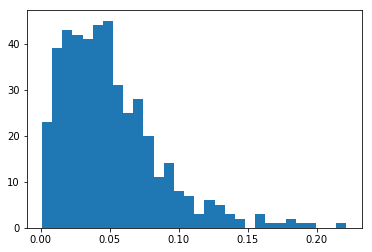

In [29]:
print(getDistance(stackreal, stackpredict).std())

plt.hist(getDistance(stackreal, stackpredict), normed=False, bins=30)

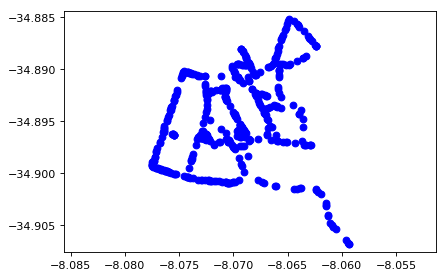

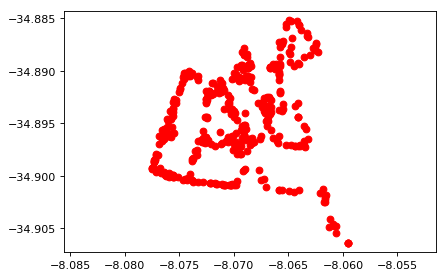

In [66]:
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(stackreal[:,0], stackreal[:,1], c='blue')
plt.margins(x=0.0, y=-0.25)
plt.show()

figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(stackpredict[:,0], stackpredict[:,1], c='red')
plt.margins(x=0.0, y=-0.25)
plt.show()